In [39]:
import json, time, urllib.parse
import requests
import pandas as pd


In [20]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<sghela@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022100100"    # this is likely the wrong end date
}

In [21]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [35]:
dinosaur_names = pd.read_csv('../data/dinosaur_genera.cleaned.SEPT.2022.csv')['name'].tolist()
dinosaur_names = dinosaur_names[1:] #removing the first broken link
#dinosaur_names

['Aachenosaurus',
 'Aardonyx',
 'Abdarainurus',
 'Abditosaurus',
 'Abelisaurus',
 'Abrictosaurus',
 'Abrosaurus',
 'Abydosaurus',
 'Acantholipan',
 'Acanthopholis',
 'Achelousaurus',
 'Acheroraptor',
 'Achillesaurus',
 'Achillobator',
 'Acristavus',
 'Acrocanthosaurus',
 'Acrotholus',
 'Actiosaurus',
 'Adamantisaurus',
 'Adasaurus',
 'Adelolophus',
 'Adeopapposaurus',
 'Adratiklit',
 'Adynomosaurus',
 'Aegyptosaurus',
 'Aeolosaurus',
 'Aepisaurus',
 'Aepyornithomimus',
 'Aerosteon',
 'Afromimus',
 'Afrovenator',
 'Agathaumas',
 'Aggiosaurus',
 'Agilisaurus',
 'Agnosphitys',
 'Agrosaurus',
 'Agujaceratops',
 'Agustinia',
 'Ahshislepelta',
 'Ajkaceratops',
 'Ajnabia',
 'Akainacephalus',
 'Alamosaurus',
 'Alaskacephale',
 'Albalophosaurus',
 'Albertaceratops',
 'Albertadromeus',
 'Albertavenator',
 'Albertonykus',
 'Albertosaurus',
 'Albinykus',
 'Albisaurus',
 'Alcovasaurus',
 'Alectrosaurus',
 'Aletopelta',
 'Algoasaurus',
 'Alioramus',
 'Allosaurus',
 'Almas ukhaa',
 'Alnashetri',
 'Al

In [34]:
#desktop data
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["access"]="desktop"
desktop_dinosaur={}
for dinosaur_name in dinosaur_names:
    months = request_pageviews_per_article(dinosaur_name)['items']
    for month in months:
        del month['access']
    desktop_dinosaur[dinosaur_name] = months
with open('../data/dino_monthly_desktop_201501-202209.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"][:6],ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"][:6]), 'w', encoding='utf-8') as f:
    json.dump(desktop_dinosaur_dict, f, ensure_ascii=False, indent=4)
    

In [36]:
#mobile data
mobile_dinosaur={}
for dinosaur_name in dinosaur_names:
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["access"]="mobile-web"
    mobile_web_months = request_pageviews_per_article(dinosaur_name)['items']
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["access"]="mobile-app"
    mobile_app_months = request_pageviews_per_article(dinosaur_name)['items']
    assert len(mobile_web_months) == len(mobile_app_months)
    for i in range(len(mobile_web_months)):
        assert mobile_web_months[i]['timestamp'] ==  mobile_app_months[i]['timestamp'] 
        mobile_web_months[i]['views'] = mobile_web_months[i]['views'] + mobile_app_months[i]['views']
        del mobile_web_months[i]['access']
    mobile_months = mobile_web_months
    mobile_dinosaur[dinosaur_name] = mobile_months
with open('../data/dino_monthly_mobile_201501-202209.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"][:6],ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"][:6]), 'w', encoding='utf-8') as f:
    #We save and transform the dictionary into JSON
    json.dump(mobile_dinosaur, f, ensure_ascii=False, indent=4)


In [38]:
#monthly cumulative
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["access"]="all-access"
cumulative_dinosaur={}
for dinosaur_name in dinosaur_names:
    months = request_pageviews_per_article(dinosaur_name)['items']
    cum_sum=0
    for month in months:
        cum_sum+=month['views']
        month['views']=cum_sum
        del month['access']
    cumulative_dinosaur[dinosaur_name] = months
with open('../data/dino_monthly_cumulative_201501-202209.json'.format(ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["start"][:6],ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE["end"][:6]), 'w', encoding='utf-8') as f:
    json.dump(cumulative_dinosaur, f, ensure_ascii=False, indent=4)


In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as dt
from datetime import datetime

In [47]:
desktop_data = json.load(open("../data/dino_monthly_desktop_201501-202209.json"))
mobile_data = json.load(open("../data/dino_monthly_mobile_201501-202209.json")) 


In [48]:
def find_avg_views(data):
    avg_views = {}
    for title,items in data.items():
        sum_views = 0
        for month in items:
            sum_views += month['views']
        avg_views[title] = sum_views/(len(items))
    views = list(avg_views.values())
    titles = list(avg_views.keys())
    max_title = titles[views.index(max(views))]
    print(max_title)
    min_title = titles[views.index(min(views))]
    print(min_title)
    return (max_title, min_title)

In [49]:
desktop_max, desktop_min = find_avg_views(desktop_data)
mobile_max, mobile_min = find_avg_views(mobile_data)
avg_values = {'desktop_max_'+desktop_max: desktop_data[desktop_max], 'desktop_min_'+desktop_min: desktop_data[desktop_min],
                'mobile_max_'+mobile_max: mobile_data[mobile_max], 'mobile_min_'+mobile_min: mobile_data[mobile_min]}

Tyrannosaurus
Honghesaurus
Tyrannosaurus
Honghesaurus


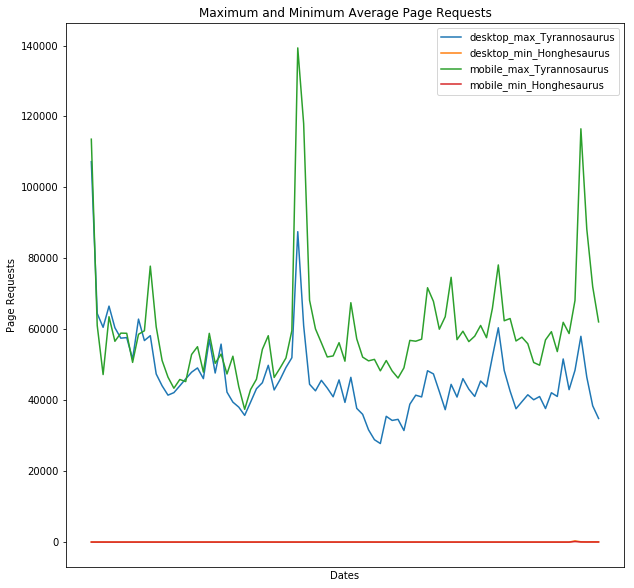

In [51]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)  
for title, items in avg_values.items():
    dates_full = [month["timestamp"] for month in items]
    dates = [datetime.strptime(date, '%Y%m%d00').strftime('%m/%d/%Y') for date in dates_full]
    views = [month["views"] for month in items]
    plt.plot(dates, views, label=title)
ax.xaxis.set_major_locator(dt.DayLocator(interval=3))
plt.title("Maximum and Minimum Average Page Requests")
plt.xlabel("Dates")
plt.ylabel("Page Requests")
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.savefig("../results/maximum_minimum_average.png", facecolor='white')
plt.show()

In [52]:
def find_peak_views(data):
    peak_views = {}
    for title,items in data.items():
        top_page_view = 0
        for month in items:
            top_page_view = max(top_page_view, int(month['views']))
        peak_views[title] = top_page_view
    sorted_views = sorted(peak_views, key=peak_views.get, reverse= True)[:10]
    print(sorted_views)
    return sorted_views

In [53]:
desktop_peak = find_peak_views(desktop_data)
mobile_peak = find_peak_views(mobile_data)
peak_values = {}
for title in desktop_peak:
    peak_values["desktop_"+title] = desktop_data[title]
for title in mobile_peak:
    peak_values["mobile_"+title] = mobile_data[title]

['Achelousaurus', 'Velociraptor', 'Tyrannosaurus', 'Halszkaraptor', 'Giganotosaurus', 'Spinosaurus', 'Lythronax', 'Nigersaurus', 'Borealopelta', 'Dilophosaurus']
['Nigersaurus', 'Deinocheirus', 'Giganotosaurus', 'Therizinosaurus', 'Velociraptor', 'Achelousaurus', 'Tyrannosaurus', 'Borealopelta', 'Dilophosaurus', 'Argentinosaurus']


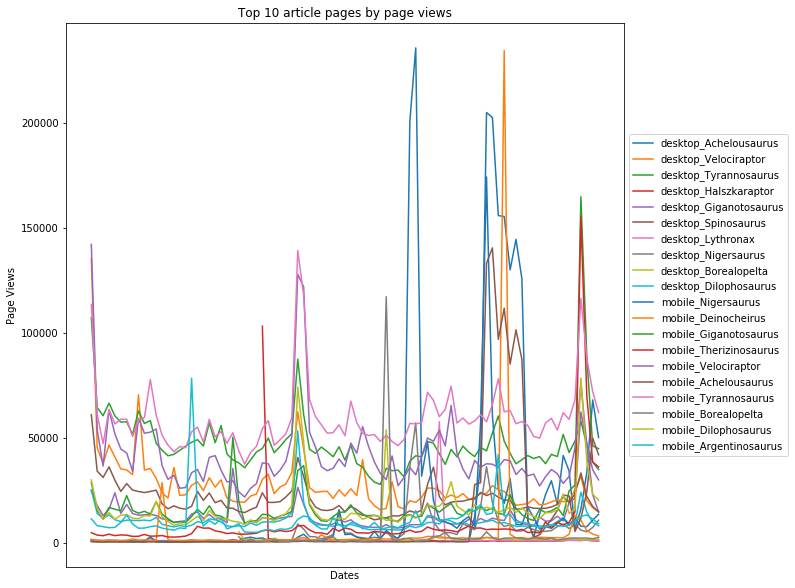

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)  
for title, items in peak_values.items():
    dates_full = [month["timestamp"] for month in items]
    dates = [datetime.strptime(date, '%Y%m%d00').strftime('%m/%d/%Y') for date in dates_full]
    views = [month["views"] for month in items]
    plt.plot(dates, views, label=title)
ax.xaxis.set_major_locator(dt.DayLocator(interval=3))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Top 10 article pages by page views")
plt.xlabel("Dates")
plt.ylabel("Page Views")
#plt.legend()
plt.xticks(rotation=45, ha='right')
plt.savefig("../results/top_ten_peaks.png", bbox_inches="tight", facecolor='white')
plt.show()

In [55]:
def find_least_data(data):
    month_len = {}
    for title,item in data.items():
        month_len[title] = len(item)
    sorted_month_len = sorted(month_len, key=month_len.get)[:10]
    print(sorted_month_len)
    return list(reversed(sorted_month_len))

In [56]:
desktop_months = find_least_data(desktop_data)
mobile_months = find_least_data(mobile_data)
month_values = {}
for title in desktop_months:
    month_values["desktop_"+title] = desktop_data[title]
for title in mobile_months:
    month_values["mobile_"+title] = mobile_data[title]

['Elemgasem', 'Tuebingosaurus', 'Bisticeratops', 'Jakapil', 'Mbiresaurus', 'Perijasaurus', 'Iyuku', 'Paralitherizinosaurus', 'Bashanosaurus', 'Dzharaonyx']
['Elemgasem', 'Tuebingosaurus', 'Bisticeratops', 'Jakapil', 'Mbiresaurus', 'Perijasaurus', 'Iyuku', 'Paralitherizinosaurus', 'Bashanosaurus', 'Dzharaonyx']


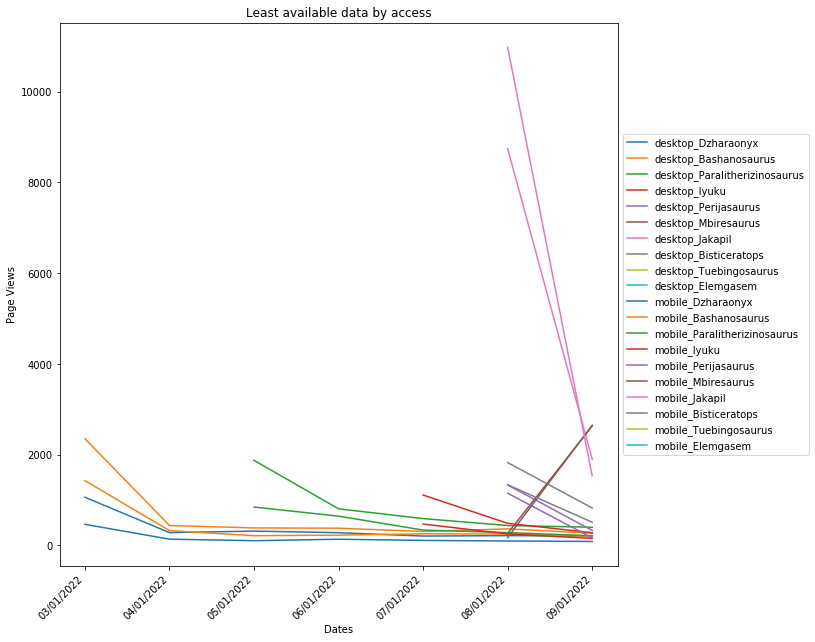

In [57]:

from datetime import datetime

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)  
for title, items in month_values.items():
    dates_full = [month["timestamp"] for month in items]
    dates = [datetime.strptime(date, '%Y%m%d00').strftime('%m/%d/%Y') for date in dates_full]
    views = [month["views"] for month in items]
    plt.plot(dates, views, label=title)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Least available data by access")
plt.xlabel("Dates")
plt.ylabel("Page Views")
#plt.legend()
plt.xticks(rotation=45, ha='right')
plt.savefig("../results/fewest_months.png", bbox_inches="tight", facecolor='white')
plt.show()